# Crystal Cell Parameter Refinement Tutorial

This notebook demonstrates how to use nanoBragg's differentiable simulator to refine crystal parameters against a target diffraction pattern.

**What you'll learn:**
1. Setting up the simulator (Crystal, Detector, Beam)
2. Generating synthetic diffraction patterns
3. Visualizing diffraction images
4. Running gradient-based refinement
5. Monitoring convergence
6. Verifying gradients with finite differences

In [41]:
# Environment setup
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["NANOBRAGG_DISABLE_COMPILE"] = "1"

import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
print(f"Using device: {device}")

Using device: cuda


## 1. Import nanoBragg Components

In [42]:
from nanobrag_torch.simulator import Simulator
from nanobrag_torch.config import (
    CrystalConfig, DetectorConfig, BeamConfig, DetectorConvention
)
from nanobrag_torch.models.crystal import Crystal
from nanobrag_torch.models.detector import Detector

## 2. Configure the Experiment

In [43]:
TRUE_CELL_A = 100.0  # Ground truth

crystal_config = CrystalConfig(
    cell_a=TRUE_CELL_A, cell_b=100.0, cell_c=100.0,
    cell_alpha=90.0, cell_beta=90.0, cell_gamma=90.0,
    N_cells=(5, 5, 5), default_F=100.0
)

detector_config = DetectorConfig(
    distance_mm=100.0, pixel_size_mm=0.1,
    spixels=256, fpixels=256,
    detector_convention=DetectorConvention.MOSFLM
)

beam_config = BeamConfig(wavelength_A=1.5)

print(f"Crystal: {crystal_config.cell_a} x {crystal_config.cell_b} x {crystal_config.cell_c} Å")
print(f"Detector: {detector_config.spixels} x {detector_config.fpixels} pixels")

Crystal: 100.0 x 100.0 x 100.0 Å
Detector: 256 x 256 pixels


## 3. Create Components and Generate Target

In [44]:
crystal = Crystal(crystal_config, device=device, dtype=dtype)
detector = Detector(detector_config, device=device, dtype=dtype)

simulator = Simulator(crystal=crystal, detector=detector, beam_config=beam_config)
with torch.no_grad():
    target = simulator.run()

print(f"Target shape: {target.shape}")
print(f"Intensity range: [{target.min():.2e}, {target.max():.2e}]")

auto-selected 1-fold oversampling
[HKL stats] h=[-1,-0] k=[-8,8] l=[-8,8] hit_rate=65536/65536 (100.00%)
Target shape: torch.Size([256, 256])
Intensity range: [5.22e-13, 1.31e+02]


## 4. Visualize the Target Pattern

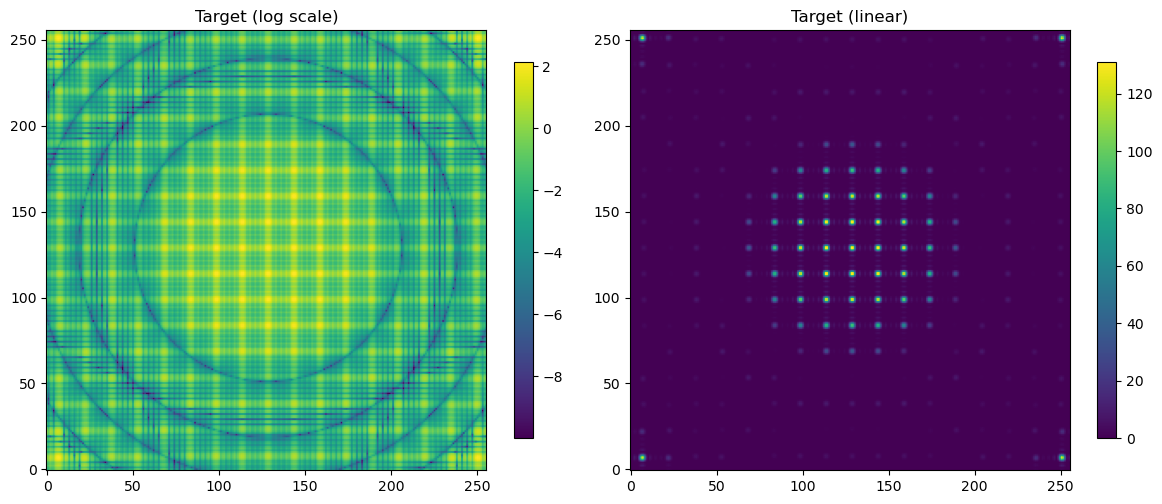

In [45]:
def plot_pattern(pattern, title="", log_scale=True, ax=None):
    if isinstance(pattern, torch.Tensor):
        img = pattern.detach().cpu().numpy()
    else:
        img = pattern
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    if log_scale:
        img = np.log10(img + 1e-10)
    im = ax.imshow(img, origin='lower', cmap='viridis')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, shrink=0.8)
    return ax

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_pattern(target, "Target (log scale)", log_scale=True, ax=axes[0])
plot_pattern(target, "Target (linear)", log_scale=False, ax=axes[1])
plt.tight_layout()
plt.show()

## 5. Set Up Refinement (5% Initial Error)

In [46]:
INIT_CELL_A = 95.0

# Create learnable parameter
cell_a = torch.tensor(INIT_CELL_A, device=device, dtype=dtype, requires_grad=True)

# Update crystal in-place (efficient!)
crystal.cell_a = cell_a

print(f"Initial: {cell_a.item():.2f} Å")
print(f"Target:  {TRUE_CELL_A:.2f} Å")
print(f"Error:   {abs(cell_a.item() - TRUE_CELL_A):.2f} Å ({abs(cell_a.item() - TRUE_CELL_A)/TRUE_CELL_A*100:.1f}%)")

Initial: 95.00 Å
Target:  100.00 Å
Error:   5.00 Å (5.0%)


## 6. Compare Initial vs Target

auto-selected 1-fold oversampling
[HKL stats] h=[-1,-0] k=[-8,8] l=[-8,8] hit_rate=65536/65536 (100.00%)


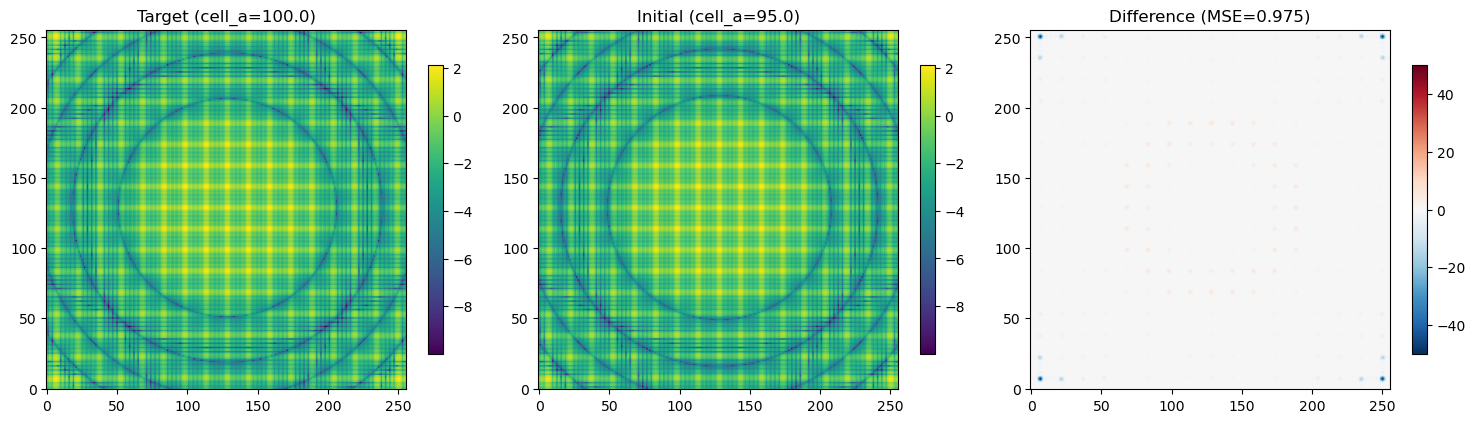

In [47]:
sim_init = Simulator(crystal=crystal, detector=detector, beam_config=beam_config)
with torch.no_grad():
    initial_pattern = sim_init.run()

initial_mse = torch.mean((initial_pattern - target) ** 2).item()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
plot_pattern(target, f"Target (cell_a={TRUE_CELL_A})", ax=axes[0])
plot_pattern(initial_pattern, f"Initial (cell_a={INIT_CELL_A})", ax=axes[1])

diff = (initial_pattern - target).cpu().numpy()
im = axes[2].imshow(diff, origin='lower', cmap='RdBu_r', vmin=-abs(diff).max(), vmax=abs(diff).max())
axes[2].set_title(f'Difference (MSE={initial_mse:.3f})')
plt.colorbar(im, ax=axes[2], shrink=0.8)
plt.tight_layout()
plt.show()

## 7. Run Refinement

In [48]:
optimizer = torch.optim.Adam([cell_a], lr=0.5)
history = {'cell_a': [], 'loss': []}

print(f"Refining: {INIT_CELL_A:.1f} → {TRUE_CELL_A:.1f} Å")
print("-" * 45)

for step in range(30):
    optimizer.zero_grad()
    sim = Simulator(crystal=crystal, detector=detector, beam_config=beam_config)
    pattern = sim.run()
    loss = torch.mean((pattern - target) ** 2)
    loss.backward()
    optimizer.step()
    
    history['cell_a'].append(cell_a.item())
    history['loss'].append(loss.item())
    
    if step % 5 == 0:
        print(f"Step {step:2d}: cell_a={cell_a.item():.3f} Å, loss={loss.item():.2e}")

print("-" * 45)
print(f"Final: cell_a={cell_a.item():.3f} Å (error: {abs(cell_a.item()-TRUE_CELL_A):.3f} Å)")

Refining: 95.0 → 100.0 Å
---------------------------------------------
auto-selected 1-fold oversampling
[HKL stats] h=[-1,-0] k=[-8,8] l=[-8,8] hit_rate=65536/65536 (100.00%)
Step  0: cell_a=95.500 Å, loss=9.75e-01
auto-selected 1-fold oversampling
[HKL stats] h=[-1,-0] k=[-8,8] l=[-8,8] hit_rate=65536/65536 (100.00%)
auto-selected 1-fold oversampling
[HKL stats] h=[-1,-0] k=[-8,8] l=[-8,8] hit_rate=65536/65536 (100.00%)
auto-selected 1-fold oversampling
[HKL stats] h=[-1,-0] k=[-8,8] l=[-8,8] hit_rate=65536/65536 (100.00%)
auto-selected 1-fold oversampling
[HKL stats] h=[-1,-0] k=[-8,8] l=[-8,8] hit_rate=65536/65536 (100.00%)
auto-selected 1-fold oversampling
[HKL stats] h=[-1,-0] k=[-8,8] l=[-8,8] hit_rate=65536/65536 (100.00%)
Step  5: cell_a=97.927 Å, loss=2.47e-01
auto-selected 1-fold oversampling
[HKL stats] h=[-1,-0] k=[-8,8] l=[-8,8] hit_rate=65536/65536 (100.00%)
auto-selected 1-fold oversampling
[HKL stats] h=[-1,-0] k=[-8,8] l=[-8,8] hit_rate=65536/65536 (100.00%)
auto-sele

## 8. Visualize Convergence

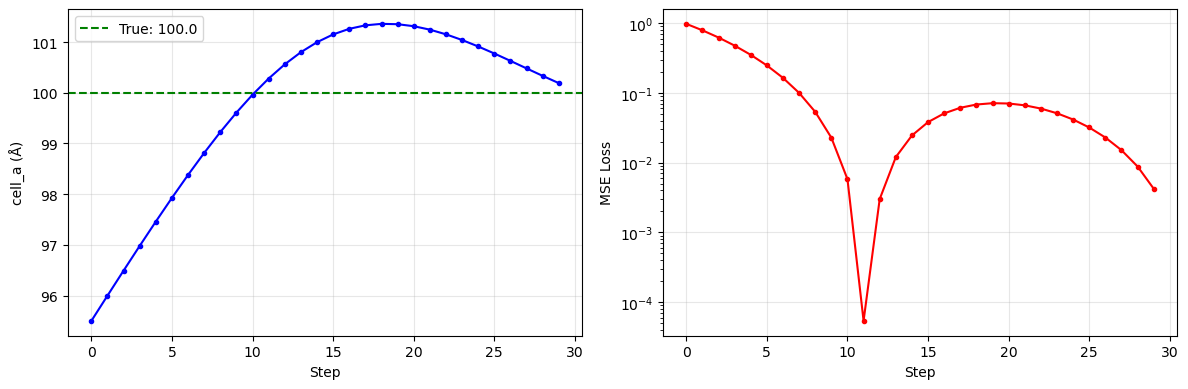

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['cell_a'], 'b-o', markersize=3)
axes[0].axhline(TRUE_CELL_A, color='g', linestyle='--', label=f'True: {TRUE_CELL_A}')
axes[0].set_xlabel('Step'); axes[0].set_ylabel('cell_a (Å)')
axes[0].legend(); axes[0].grid(alpha=0.3)

axes[1].semilogy(history['loss'], 'r-o', markersize=3)
axes[1].set_xlabel('Step'); axes[1].set_ylabel('MSE Loss')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Gradient Verification

When developing differentiable code, verify analytical gradients match numerical (finite difference) gradients.

In [50]:
def compute_loss(cell_a_val):
    """Compute loss for a given cell_a value."""
    cfg = CrystalConfig(
        cell_a=float(cell_a_val), cell_b=100.0, cell_c=100.0,
        cell_alpha=90.0, cell_beta=90.0, cell_gamma=90.0,
        N_cells=(5, 5, 5), default_F=100.0
    )
    crys = Crystal(cfg, device=device, dtype=dtype)
    sim = Simulator(crystal=crys, detector=detector, beam_config=beam_config)
    with torch.no_grad():
        pat = sim.run()
    return torch.mean((pat - target) ** 2).item()

# Finite difference gradient
test_val = 98.0
eps = 0.01
numerical_grad = (compute_loss(test_val + eps) - compute_loss(test_val - eps)) / (2 * eps)

# Analytical gradient
cell_a_test = torch.tensor(test_val, device=device, dtype=dtype, requires_grad=True)
crystal.cell_a = cell_a_test
sim = Simulator(crystal=crystal, detector=detector, beam_config=beam_config)
loss = torch.mean((sim.run() - target) ** 2)
loss.backward()
analytical_grad = cell_a_test.grad.item()

print("Gradient Comparison")
print("=" * 40)
print(f"Numerical (finite diff): {numerical_grad:.6f}")
print(f"Analytical (autograd):   {analytical_grad:.6f}")
rel_err = abs(analytical_grad - numerical_grad) / (abs(numerical_grad) + 1e-10)
print(f"Relative error:          {rel_err:.2e}")
print(f"Status: {'PASS' if rel_err < 0.05 else 'FAIL'}")

auto-selected 1-fold oversampling
[HKL stats] h=[-1,-0] k=[-8,8] l=[-8,8] hit_rate=65536/65536 (100.00%)
auto-selected 1-fold oversampling
[HKL stats] h=[-1,-0] k=[-8,8] l=[-8,8] hit_rate=65536/65536 (100.00%)
auto-selected 1-fold oversampling
[HKL stats] h=[-1,-0] k=[-8,8] l=[-8,8] hit_rate=65536/65536 (100.00%)
Gradient Comparison
Numerical (finite diff): -0.153714
Analytical (autograd):   -0.153619
Relative error:          6.14e-04
Status: PASS


## 10. Using torch.autograd.gradcheck

For rigorous verification, use `gradcheck` with float64 precision.

In [51]:
from torch.autograd import gradcheck

# Small detector for speed, float64 for precision
det_small = Detector(
    DetectorConfig(distance_mm=100.0, pixel_size_mm=0.1, spixels=32, fpixels=32,
                   detector_convention=DetectorConvention.MOSFLM),
    device=device, dtype=torch.float64
)

def loss_fn(cell_a_in):
    cfg = CrystalConfig(cell_a=100.0, cell_b=100.0, cell_c=100.0,
                        cell_alpha=90.0, cell_beta=90.0, cell_gamma=90.0,
                        N_cells=(5, 5, 5), default_F=100.0)
    crys = Crystal(cfg, device=device, dtype=torch.float64)
    crys.cell_a = cell_a_in
    sim = Simulator(crystal=crys, detector=det_small, beam_config=beam_config)
    return sim.run().sum().unsqueeze(0)

inp = torch.tensor([98.0], device=device, dtype=torch.float64, requires_grad=True)

print("Running gradcheck...")
try:
    gradcheck(loss_fn, inp, eps=1e-4, atol=1e-4, rtol=1e-3, raise_exception=True)
    print("gradcheck PASSED")
except Exception as e:
    print(f"gradcheck FAILED: {e}")

Running gradcheck...
auto-selected 1-fold oversampling
gradcheck FAILED: Expected size for first two dimensions of batch2 tensor to be: [3, 3] but got: [3, 1].


## Summary

This notebook demonstrated:
1. **Simulator setup** - Crystal, Detector, Beam configurations
2. **Pattern generation** - `simulator.run()` returns differentiable 2D tensor
3. **In-place updates** - Update `crystal.cell_a` directly without reallocation
4. **Gradient refinement** - Adam optimizer minimizes MSE loss
5. **Gradient verification** - Manual finite differences and `gradcheck`

The simulator is **fully differentiable** - gradients flow from loss through the entire physics simulation back to crystal parameters.